In [113]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to C:\Users\ramav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [115]:
# Load the dataset
file_path = r"C:\Users\ramav\Downloads\archive (3)\spam.csv"
df = pd.read_csv(file_path, encoding='latin-1')

# Display first few rows
print(df.head())


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [117]:
# Check basic info about the dataset
print(df.info())








<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [119]:
# Display summary statistics of numerical columns (not useful here but included)
print(df.describe())

          v1                      v2  \
count   5572                    5572   
unique     2                    5169   
top      ham  Sorry, I'll call later   
freq    4825                      30   

                                               Unnamed: 2  \
count                                                  50   
unique                                                 43   
top      bt not his girlfrnd... G o o d n i g h t . . .@"   
freq                                                    3   

                   Unnamed: 3 Unnamed: 4  
count                      12          6  
unique                     10          5  
top      MK17 92H. 450Ppw 16"    GNT:-)"  
freq                        2          2  


In [121]:
# Check for duplicated values
print("Number of duplicate rows:", df.duplicated().sum())

Number of duplicate rows: 403


In [123]:
# Drop duplicate rows if needed
df = df.drop_duplicates()

In [125]:
# Drop unnecessary columns
df = df[['v1', 'v2']]
df.columns = ['label', 'message']  # Rename columns

# Convert label to binary (spam=1, ham=0)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Check for missing values
print("Missing values:\n", df.isnull().sum())


Missing values:
 label      0
message    0
dtype: int64


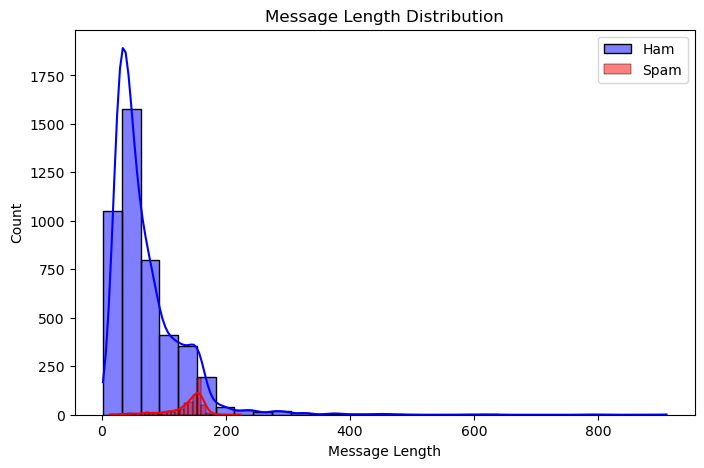

In [127]:
# Create a new column for message length
df['message_length'] = df['message'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df[df['label']==0]['message_length'], bins=30, color='blue', label='Ham', kde=True)
sns.histplot(df[df['label']==1]['message_length'], bins=30, color='red', label='Spam', kde=True)
plt.legend()
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.show()


C:\Users\ramav\AppData\Local\Temp\ipykernel_8476\316727677.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette=['blue', 'red'])


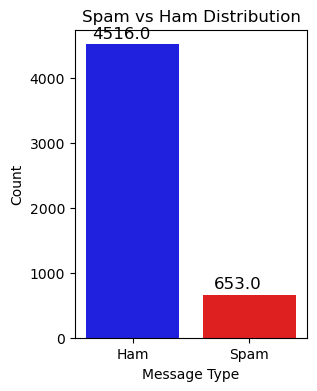

In [128]:
# Count of spam vs. ham messages
plt.figure(figsize=(3,4))
sns.countplot(data=df, x='label', palette=['blue', 'red'])
plt.xticks(ticks=[0,1], labels=['Ham', 'Spam'])
plt.title('Spam vs Ham Distribution')
plt.xlabel('Message Type')
plt.ylabel('Count')

# Show values on bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', (p.get_x() + 0.3, p.get_height() + 100), ha='center', fontsize=12)

plt.show()


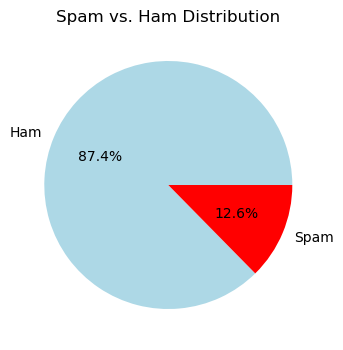

In [130]:
# Pie chart of spam vs. ham
plt.figure(figsize=(4,6))
df['label'].value_counts().plot.pie(autopct='%1.1f%%', colors=['lightblue', 'red'], labels=['Ham', 'Spam'])
plt.title("Spam vs. Ham Distribution")
plt.ylabel('')
plt.show()


In [133]:
stop_words = set(stopwords.words('english'))  # Load stopwords once

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()  # Tokenization using split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    return ' '.join(words)

# Apply text cleaning
df['cleaned_message'] = df['message'].apply(clean_text)

# Display cleaned messages
print(df[['message', 'cleaned_message']].head())


                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                     cleaned_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts st ...  
3                u dun say early hor u c already say  
4        nah dont think goes usf lives around though  


In [135]:
# Convert text data into numerical form using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Use top 5000 words
X = vectorizer.fit_transform(df['cleaned_message'])
y = df['label']

print("Shape of TF-IDF feature matrix:", X.shape)


Shape of TF-IDF feature matrix: (5169, 5000)


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Model Accuracy: 0.9497
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       903
           1       0.99      0.61      0.75       131

    accuracy                           0.95      1034
   macro avg       0.97      0.80      0.86      1034
weighted avg       0.95      0.95      0.94      1034



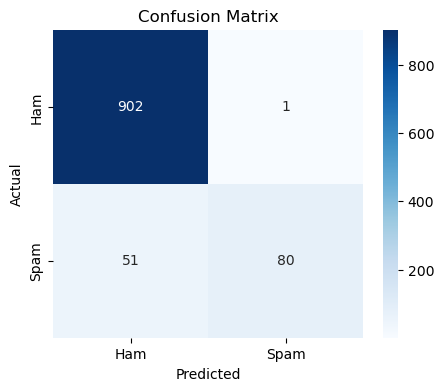

In [139]:
# Train a Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Naïve Bayes Accuracy: 0.9662
Classification Report for Naïve Bayes:

              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       903
        Spam       0.99      0.74      0.85       131

    accuracy                           0.97      1034
   macro avg       0.98      0.87      0.91      1034
weighted avg       0.97      0.97      0.96      1034



<function matplotlib.pyplot.show(close=None, block=None)>

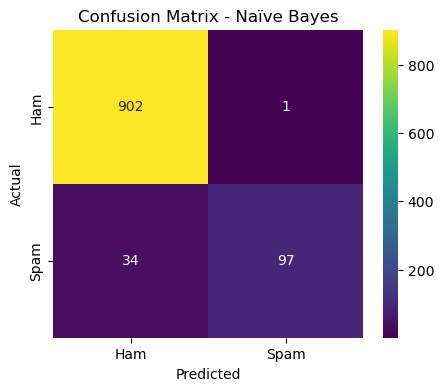

In [158]:
# Train Naïve Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions
y_pred_nb = nb_model.predict(X_test)

# Evaluate Performance
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naïve Bayes Accuracy: {accuracy_nb:.4f}")

# Precision, Recall, and F1-score
print("Classification Report for Naïve Bayes:\n")
print(classification_report(y_test, y_pred_nb, target_names=['Ham', 'Spam']))
# Compute Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="viridis", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Naïve Bayes")
plt.show


SVM Accuracy: 0.9758

Classification Report for SVM:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       903
        Spam       0.97      0.83      0.90       131

    accuracy                           0.98      1034
   macro avg       0.97      0.91      0.94      1034
weighted avg       0.98      0.98      0.98      1034



Text(33.22222222222222, 0.5, 'Actual')

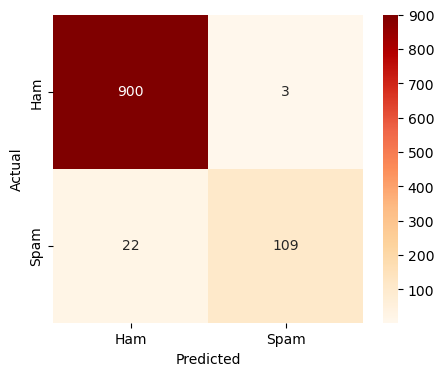

In [164]:
 #Train SVM Model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate Performance
accuracy_nb = accuracy_score(y_test, y_pred_nb)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm:.4f}")

# Classification Report for SVM
print("\nClassification Report for SVM:")
print(classification_report(y_test, y_pred_svm, target_names=['Ham', 'Spam']))
# Compute Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Plot Confusion Matrix with a different color
plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="OrRd", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")


In [144]:
def predict_spam(message):
    cleaned_message = clean_text(message)
    vectorized_message = vectorizer.transform([cleaned_message])
    prediction = model.predict(vectorized_message)
    return "Spam" if prediction[0] == 1 else "Not Spam"

# Test example
new_message = "Congratulations! You've won a free iPhone! Click here to claim now."
print(f"Prediction: {predict_spam(new_message)}")


Prediction: Spam


                 Model  Accuracy
0  Logistic Regression  0.949710
1          Naïve Bayes  0.966151
2                  SVM  0.975822

Best Model: SVM with Accuracy: 0.98


C:\Users\ramav\AppData\Local\Temp\ipykernel_8476\81596852.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Model", data=acc_df, palette="coolwarm")


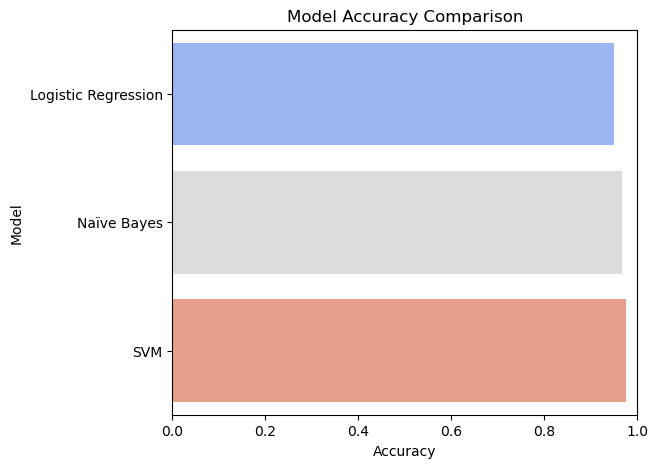

In [147]:
# Train and evaluate multiple models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Naïve Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear')
}

accuracies = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, y_pred)

# Convert to DataFrame for visualization
acc_df = pd.DataFrame(list(accuracies.items()), columns=["Model", "Accuracy"])

# Identify the best model
best_model = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_model]

# Print accuracies
print(acc_df)
print(f"\nBest Model: {best_model} with Accuracy: {best_accuracy:.2f}")

# Plot accuracies
plt.figure(figsize=(6, 5))
sns.barplot(x="Accuracy", y="Model", data=acc_df, palette="coolwarm")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Model Accuracy Comparison")
plt.xlim(0, 1)
plt.show()
